In [1]:
%load_ext autoreload
%autoreload 1

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import itertools

# for checks and comparisons only
from sklearn.linear_model import Lasso, Ridge, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

%aimport optim
%aimport losses
%aimport regularization

# Optimization project

**Objectives**
- study the effects of several regularization techniques: Ridge, Lasso, Elastic Net, Group Lasso
- implement the ISTA algorithm for these different techniques

We want to study the linear regression problem:
\begin{equation}
    \min_{w}  \frac{1}{2n} ||Xw-y||^2
\end{equation}
With regularization function $g$, it gives the following problem:
\begin{equation}
    \min_{w}  \frac{1}{2n} ||Xw-y||^2 + \lambda g(w)
\end{equation}

Let's recap the IAST algorithm:
for any convex function g, we can define the proximal operator
\begin{equation}
    prox_{g}(y) = argmin_{x} \frac{1}{2}||x-y||^{2} + g(x)
\end{equation}

The ISTA algorithm enables to solve the problem of minimization of a sum of functions
\begin{equation}
    \min_{w}  f(w) + g(w)
\end{equation}
where $f$ is convex and $L$-smooth, and g is convex and continuous, and whose proximal operator is not difficult to calculate.


Then the ISTA algorithm consists in
1. initialize $w^{0}$
2. for $k=1$ until convergence, do
    $w^{k} = prox_{g/L}(w^{k-1}-\frac{1}{L}\nabla f(w^{k+1})$
3. return $w^{k}$

We saw this technique in class for the Lasso. For other regularization techniques, it is necessary to know the proximal operators. For the methods envisioned in this project, the proximal operator of the regularization function is easy to find

## Get data

The dataset can be found here http://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized
It is a dataset about the number of crimes in different geographical locations in the US. The goal is to predict the number of murders in 1995.

What is more interesting than the pure prediction performances of a model (the data dates back from 1995), is the explanatory power of the model. Some regularization techniques, especially the LASSO and the Group LASSO, will help us select the most important variables and get a sense of what the leverages would be for politicians, for example.

Also, we are in a case where the number of variables is important compared to the number of instances 147 attributes for 2215 observations). Regularization can also help to prevent overfitting, and reduce the impact of noisy, irrelevant variables.

In this section, we import data and do some basic data cleaning and preparation (standardize the data, treat missing values)

In [2]:
def preprocess_X(X_train, X_test):
    mean = np.mean(X_train,axis=0)
    std = np.std(X_train,axis=0)
    return (X_train-mean)/std, (X_test-mean)/std

def preprocess_y(y_train, y_test):
    mean = y_train.mean()
    return y_train-mean, y_test-mean

In [3]:
df = pd.read_csv('data/crimes.txt', na_values='?')
df.head()

communityname state  countyCode  communityCode  fold    pop  \
0  BerkeleyHeightstownship    NJ        39.0         5320.0     1  11980   
1           Marpletownship    PA        45.0        47616.0     1  23123   
2               Tigardcity    OR         NaN            NaN     1  29344   
3         Gloversvillecity    NY        35.0        29443.0     1  16656   
4              Bemidjicity    MN         7.0         5068.0     1  11245   

   perHoush  pctBlack  pctWhite  pctAsian  ...  burglaries  burglPerPop  \
0      3.10      1.37     91.78      6.50  ...        14.0       114.85   
1      2.82      0.80     95.57      3.44  ...        57.0       242.37   
2      2.43      0.74     94.33      3.43  ...       274.0       758.14   
3      2.40      1.70     97.35      0.50  ...       225.0      1301.78   
4      2.76      0.53     89.16      1.17  ...        91.0       728.93   

   larcenies  larcPerPop  autoTheft  autoTheftPerPop  arsons  arsonsPerPop  \
0      138.0     1132.08       16.0           131.26     2.0         16.41   
1      376.0     1598.78       26.0           110.55     1.0          4.25   
2     1797.0     4972.19      136.0           376.30    22.0         60.87   
3      716.0     4142.56       47.0           271.93     NaN           NaN   
4     1060.0     8490.87       91.0           728.93     5.0         40.05   

   violentPerPop  nonViolPerPop  
0          41.02        1394.59  
1         127.56        1955.95  
2         218.59        6167.51  
3         306.64            NaN  
4            NaN        9988.79  

[5 rows x 147 columns]

In [4]:
target_var = 'murders'
metadata_vars = ['communityname', 'state', 'countyCode', 'communityCode', 'fold']
other_target_var = ['murdPerPop','rapes','rapesPerPop','robberies','robbbPerPop','assaults','assaultPerPop','burglaries',
                    'burglPerPop','larcenies','larcPerPop','autoTheft','autoTheftPerPop','arsons','arsonsPerPop','violentPerPop',
                    'nonViolPerPop']

In [5]:
# we remove meta variables and other target variables (which would produce data leakage for the prediction)
df = df.drop(metadata_vars+other_target_var, axis=1)

# we remove missing data:
# the whole column if there are more than 10 missing values
# the line if there are at least one missing values on other columns
missing = df.isna().sum(axis=0).sort_values()
print(missing) # print nb of missing values for each variables
missing_col = missing[missing>10].index
df = df.drop(missing_col, axis=1) # we remove all columns with more than 10 missing values
# (in fact, all of the removed columns have 1872 missing values)
df_ = df.dropna() # only one line removed

pop                     0
pctVacant6up            0
pctVacantBoarded        0
pctHousOwnerOccup       0
pctHousOccup            0
                     ... 
policePerPop         1872
numPolice            1872
policBudgetPerPop    1872
pctPolicAsian        1872
policeFieldPerPop    1872
Length: 125, dtype: int64


In [6]:
# train test split
df_train, df_test = train_test_split(df_, test_size = 0.3, random_state = 42)

train_indices = df_train.index
test_indices = df_test.index

df_train, df_test = df_train.reset_index(drop=True), df_test.reset_index(drop=True)

df_train, df_test = preprocess_X(df_train, df_test)

X_train, X_test = df_train.drop('murders', axis=1).values, df_test.drop('murders', axis=1).values
y_train, y_test = df_train['murders'].values[:,None], df_test['murders'].values[:,None]

colnames = df_train.drop('murders', axis=1).columns
n,p = X_train.shape
print(n,p)

1549 102


In [7]:
# get feature names
feature_colnames = df_.drop('murders', axis=1).columns

## Simple Linear Regression

We do a simple linear regression in this section

In [15]:
def print_residuals(X,w,y, title=None):
    plt.plot(X@w, '.-', label='prediction')
    plt.plot(y, '.-', label='true value')
    plt.xlabel('observation index')
    plt.ylabel('target value')
    if title:
        plt.title(title)
    plt.legend()
    plt.show()

In [9]:
w_Reg = np.linalg.solve(X_train.T @ X_train, X_train.T @ y_train)
w_Reg

array([[-8.74136988e-01],
       [-5.19978995e-03],
       [ 5.15066559e-02],
       [ 4.57294837e-02],
       [ 1.05962882e-02],
       [ 1.08729277e-02],
       [-2.17389518e-02],
       [-2.71479440e-02],
       [ 7.99833106e-02],
       [ 1.29326821e-02],
       [ 4.43357142e-01],
       [-1.69285748e-02],
       [ 7.02315578e-02],
       [-2.02793772e-02],
       [ 1.97539237e-03],
       [-1.72541947e-02],
       [-3.55393424e-02],
       [-1.50372052e-02],
       [ 1.32397483e-02],
       [-8.89083178e-02],
       [-4.00228095e-01],
       [ 4.05014737e-01],
       [ 5.00307594e-03],
       [ 1.70674124e-03],
       [ 5.34894528e-03],
       [ 4.11015162e-03],
       [ 4.39972497e-04],
       [ 4.97651609e-01],
       [-3.74689012e-02],
       [ 6.77356976e-03],
       [ 2.02708549e-02],
       [ 7.39105174e-03],
       [ 2.40198783e-02],
       [ 5.35647073e-04],
       [ 1.18719777e-03],
       [-1.12140810e-02],
       [ 6.16607129e-03],
       [ 9.85386974e-03],
       [ 2.7

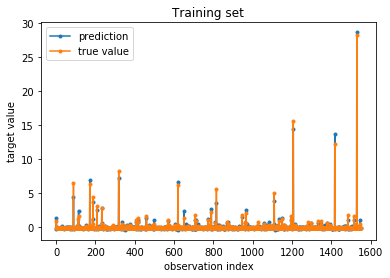

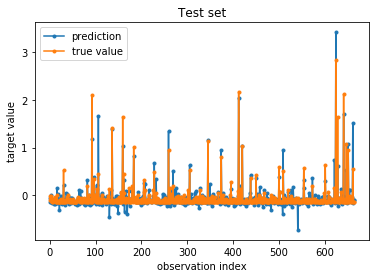

In [16]:
print_residuals(X_train,w_Reg,y_train, title='Training set')
print_residuals(X_test,w_Reg,y_test, title='Test set')

In [17]:
def mse(y_pred, y_true):
    return 1/(2*len(y_true))*np.linalg.norm(y_true - y_pred,2)**2

def relative_mse(y_pred, y_true):
    return 1/(2*len(y_true))*np.linalg.norm(y_true - y_pred,2)**2/np.linalg.norm(y_true)

print('MSE train = {:.3f}'.format(mse(X_train@w_Reg, y_train)))
print('MSE test = {:.3f}'.format(mse(X_test@w_Reg, y_test)))

print('Train error (relative)= {:.6f}'.format(relative_mse(X_train@w_Reg, y_train)))
print('Test error (relative)= {:.6f}'.format(relative_mse(X_test@w_Reg, y_test)))

MSE train = 0.010
MSE test = 0.008
Train error (relative)= 0.000254
Test error (relative)= 0.001112


## Ridge

We solve the ridge problem with the normal equations, as we can obtain the value of w on a closed formed.

We obtain easily from calculations the following equivalent formulae:
\begin{align}
    w &= (X^TX+n\lambda Id_p)^{-1}X^Ty\\
    w &= X^T(XX^T+n\lambda Id_n)^{-1}y
\end{align}

If we could not afford to inverse one of the matrices, we could fall back on the ISTA algorithm. To get the proximal operator of the regularization function, we would have to solve the following:
\begin{equation}
    prox_{g}(y) = argmin_{x} \frac{1}{2}||x-y||^{2} + \lambda ||x||^2
\end{equation}

The gradient of the function $\phi$ to optimize, which is strictly convex, is
\begin{equation}
    \nabla \phi(x) = x-y+\lambda x = 0
\end{equation}
So it yields the proximal operator
\begin{equation}
    prox_{ridge(\lambda)}(y) = \frac{y}{1+\lambda}
\end{equation}

In [23]:
# the closed form functions (two methods)
def solve_ridge_1(X,y,lbda):
    return np.linalg.solve( X.T @ X + len(X) * lbda * np.identity(p), X.T @ y)

def solve_ridge_2(X,y,lbda):
    u = np.linalg.solve( X @ X.T + len(X) * lbda * np.identity(len(X)), y)
    return X.T @ u

In [26]:
# we choose a lambda
lbda = 0.1;

In [27]:
%time
w1 = solve_ridge_1(X_train,y_train,lbda)
w1

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 10.7 µs


array([[ 1.02630446e-01],
       [ 8.12942897e-03],
       [ 2.44746482e-02],
       [-1.34140456e-02],
       [-1.35289067e-02],
       [-4.13386058e-03],
       [ 5.41351786e-03],
       [-4.09063110e-03],
       [ 4.44586682e-03],
       [ 1.63976136e-04],
       [ 1.02833099e-01],
       [-1.80719399e-02],
       [-2.83752244e-03],
       [-3.18043827e-03],
       [ 3.99342600e-03],
       [ 2.15247979e-04],
       [-8.70913691e-03],
       [-8.70968919e-03],
       [ 3.70414936e-03],
       [-1.29126475e-02],
       [-1.12976205e-02],
       [ 3.23552275e-02],
       [ 3.62470471e-03],
       [-3.38980941e-04],
       [-2.74105481e-04],
       [ 3.31690667e-03],
       [ 3.78462304e-03],
       [ 2.13041148e-01],
       [-3.02241627e-03],
       [ 4.43764516e-03],
       [ 6.86622887e-03],
       [-6.28974520e-03],
       [ 1.33463766e-02],
       [-1.80541613e-03],
       [-1.10883847e-03],
       [-6.94711246e-03],
       [-2.84589357e-04],
       [ 8.22173903e-03],
       [ 9.1

In [28]:
%time
w2 = solve_ridge_2(X_train,y_train,lbda)
w2

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


array([[ 1.02630446e-01],
       [ 8.12942897e-03],
       [ 2.44746482e-02],
       [-1.34140456e-02],
       [-1.35289067e-02],
       [-4.13386058e-03],
       [ 5.41351786e-03],
       [-4.09063110e-03],
       [ 4.44586682e-03],
       [ 1.63976136e-04],
       [ 1.02833099e-01],
       [-1.80719399e-02],
       [-2.83752244e-03],
       [-3.18043827e-03],
       [ 3.99342600e-03],
       [ 2.15247979e-04],
       [-8.70913691e-03],
       [-8.70968919e-03],
       [ 3.70414936e-03],
       [-1.29126475e-02],
       [-1.12976205e-02],
       [ 3.23552275e-02],
       [ 3.62470471e-03],
       [-3.38980941e-04],
       [-2.74105481e-04],
       [ 3.31690667e-03],
       [ 3.78462304e-03],
       [ 2.13041148e-01],
       [-3.02241627e-03],
       [ 4.43764516e-03],
       [ 6.86622887e-03],
       [-6.28974520e-03],
       [ 1.33463766e-02],
       [-1.80541613e-03],
       [-1.10883847e-03],
       [-6.94711246e-03],
       [-2.84589357e-04],
       [ 8.22173903e-03],
       [ 9.1

In [29]:
print(np.linalg.norm(w1-w2)/np.linalg.norm(w1))

6.63306327921529e-15


With our dataset, it does not really make a difference to compute with a closed form method or another. The computation time is neglectable, and the difference in result is null

We then perform validation to find the optimal value of $\lambda$ for our dataset. We use the test set as the validation set

In [89]:
n_iter = 400
q = 100
lbda_list = np.logspace(-4,1,q)

J_train_Ridge = np.zeros(q) # the energy on the training set
J_test_Ridge = np.zeros(q) # the energy on the test set
E_train_Ridge = np.zeros(q) # the relative training error
E_test_Ridge = np.zeros(q) # the relative test error
W_Ridge = np.zeros((q,p)) # the coefficients


for i,lbda in enumerate(lbda_list):
    w = solve_ridge_1(X_train,y_train,lbda)
    
    J_train_Ridge[i] = losses.LeastSquare.loss(X_train,y_train,w)+regularization.Regularization.ridge(w, lbda)
    J_test_Ridge[i] = losses.LeastSquare.loss(X_test,y_test,w)+regularization.Regularization.ridge(w, lbda)
    E_train_Ridge[i] = losses.LeastSquare.loss(X_train,y_train,w)/np.linalg.norm(y_train)
    E_test_Ridge[i] = losses.LeastSquare.loss(X_test,y_test,w)/np.linalg.norm(y_test)
    W_Ridge[i] = w.flatten()
    
# find optimal Lambda
i = E_test_Ridge.argmin(axis=0)
lambda_Ridge = lbda_list[i]
w_Ridge = W_Ridge[i][:,None]
print( 'Ridge: ' + str(E_test_Ridge.min()*100) + '%' )
print('lambda = {}'.format(lambda_Ridge))
# print('w = {}'.format(w_Ridge))

Ridge: 0.09365057727930774%
lambda = 0.013219411484660288


The error on the test set has a minimum in $\lambda_{Ridge}$, by construction.

We can see that the training loss is increasing with the value of $\lambda$, which is normal because impose more restrictions on $\lambda$. Indeed, if we take the regularization term out of the objective function and convert it to a constraint, it is clear, it is more and more restrictive on the values $\lambda$ can take, thus adding more bias and increasing the training error.
The test error is slightly decreasing, then increasing. It shows that Ridge regression helps to better generalize, even if the effect is small in this dataset

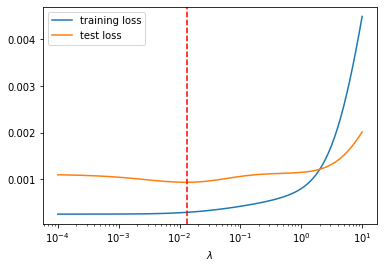

In [90]:
plt.clf
plt.plot(lbda_list, E_train_Ridge, label='training loss')
plt.plot(lbda_list, E_test_Ridge, label='test loss')
plt.axvline(lambda_Ridge, color='red', linestyle='--')
plt.xlabel('$\lambda$')
# plt.xlim(0.0001,0.01)
plt.xscale('log')
plt.legend()
plt.show()

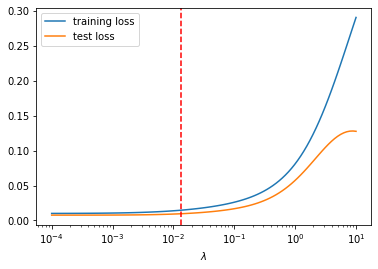

In [91]:
plt.clf
plt.plot(lbda_list, J_train_Ridge, label='training loss')
plt.plot(lbda_list, J_test_Ridge, label='test loss')
plt.axvline(lambda_Ridge, color='red', linestyle='--')
plt.xlabel('$\lambda$')
# plt.xlim(0.001,0.1)
plt.xscale('log')
plt.legend()
plt.show()

We can see that the Ridge regression do not offer sparcity properties. All the coefficients of $w$ are non zero. When the value of $\lambda$ increases, the coefficients of $w$ get closer to 0. This is the effect of the regularization. In the following graph, we see that for very low value of $\lambda$, the regularization has not effect whatsoever, and we obtain results similar to non regularized linear regression. For very large values of $\lambda$, all the coefficients reach a neighbourhood around 0.

We can still see a group of parameters that have higher coefficients. Maybe we could be able to isaolate them better with the LASSO regularization.

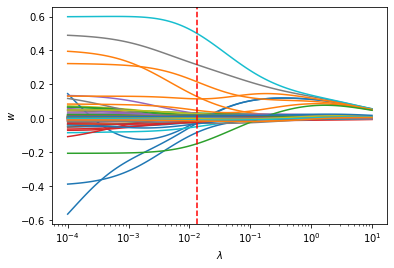

In [92]:
for k in range(p):
    plt.plot(lbda_list, W_Ridge[:,k])
plt.xlabel('$\lambda$')
plt.ylabel('$w$')
plt.axvline(lambda_Ridge, color='red', linestyle='--')
plt.xscale('log')
# plt.legend()
plt.show()

## Lasso

We solve the Lasso problem with the ISTA algorithm. The proximal operator verifies
\begin{equation}
    prox_{lasso(\lambda)}(y) = argmin_{x} \frac{1}{2}||x-y||^{2} + \lambda ||x||_{1}
\end{equation}

We saw in class the equation of the proximal operator: it is the soft function:
So it yields the proximal operator
\begin{equation}
    prox_{lasso(\lambda)}(y) = sign(y) * (|y|-\lambda)_{+}
\end{equation}

In this section, we will:
- check the convergence
- choose the optimal value for $\lambda$
- check the variation of the coefficients of $w$ as a function of $\lambda$ and observe the sparcity effect

In [23]:
# take the operator norm of X
X_norm = losses.LeastSquare.L(X_train.T @ X_train)
tau = 1/X_norm

### Test of convergence of the method

Let's try for one value of $\lambda$

In [94]:
lbda = 0.1
n_iter = 400
iast = optim.IAST(losses.LeastSquare, 'lasso', lbda=lbda)
iast.multiple_steps(X_train, y_train, tau=tau, n=200)
# iast.single_step(X_train, y_train, np.zeros((X_train.shape[1],1)), tau)

array([[ 0.11517934],
       [ 0.        ],
       [ 0.        ],
       [-0.        ],
       [-0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [ 0.11479993],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [ 0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [ 0.12527935],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.        ],
       [ 0.        ],
       [-0.        ],
       [-0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.        ],
       [-0.        ],
       [-0

The result clearly eliminates a lot of features.

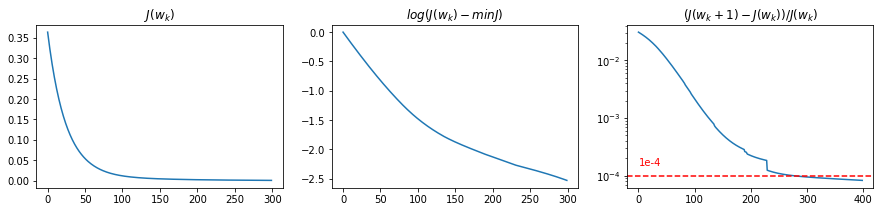

In [95]:
n_iter = 400
max_idx = 300
iast = optim.IAST(losses.LeastSquare, 'lasso', lbda=lbda)
iast.multiple_steps(X_train, y_train, tau=tau, n=n_iter)

e=np.log10(iast.data['J'][:max_idx]-np.min(iast.data['J']) +1e-20)

plt.clf
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
ax[0].set_title('$J(w_k)$')
ax[1].set_title('$log(J(w_k)-min J)$')
ax[2].set_title('$(J(w_k+1)-J(w_k))/J(w_k)$')

ax[0].plot(iast.data['J'][:max_idx]-iast.data['J'][-1])
ax[1].plot(e-e[0])
ax[2].plot(-np.diff(iast.data['J'])/iast.data['J'][1:])
ax[2].axhline(1e-4, color='red', linestyle='--')
ax[2].text(0, 0.00015, '1e-4', color='red')
ax[2].set_yscale('log')

ax[0].axis('tight')
ax[1].axis('tight')

plt.show()

The plot above shows:
- on the right: the convergence of the energy as a function of the number of iteration: we see that the energy converges to a value close to 0
- in the middle: the log of the difference with min(J), which is at the last iteration. We get closer to -2.5, at the 300th iteration, so the difference is lower than 0.01
- on the right: the relative difference between two consecutive iterations. At around 300 iterations, we hit a threshold of 0.0001. We will consider that 400 iterations is enough for convergence

### Find a good lambda

We do a grid search on $\lambda$ and use the test set as a validation set, to find an optimal value for $\lambda$

In [96]:
n_iter = 400
q = 100
lbda_list = np.logspace(-4,1,q)

E_train_Sparse = np.zeros(q)
E_test_Sparse = np.zeros(q)
W_Sparse = np.zeros((q,n_iter,p))


for i,lbda in enumerate(lbda_list):
    iast = optim.IAST(losses.LeastSquare, 'lasso', lbda=lbda)
    w = iast.multiple_steps(X_train, y_train, tau=tau, n=n_iter)
    
    E_train_Sparse[i] = iast.loss.loss(X_train,y_train,w)/np.linalg.norm(y_train)
    E_test_Sparse[i] = iast.loss.loss(X_test,y_test,w)/np.linalg.norm(y_test)
    W_Sparse[i] = iast.data['W']
    
# find optimal Lambda
i = E_test_Sparse.argmin()
lambda_Sparse = lbda_list[i]
w_Sparse = W_Sparse[i,-1,:][:,None]
print( 'Lasso: ' + str(E_test_Sparse.min()*100) + '%' )
print('lambda = {}'.format(lambda_Sparse))
# print('w = {}'.format(w_Sparse))

Lasso: 0.11235672100435568%
lambda = 0.04229242874389499


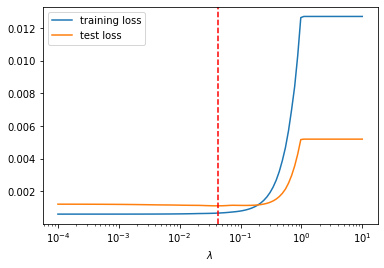

In [97]:
plt.clf
plt.plot(lbda_list, E_train_Sparse, label='training loss')
plt.plot(lbda_list, E_test_Sparse, label='test loss')
plt.axvline(lambda_Sparse, color='red', linestyle='--')
plt.xlabel('$\lambda$')
# plt.xlim(0.001,0.1)
plt.xscale('log')
plt.legend()
plt.show()

We see in the following plot the sparcity power of the Lasso regularization. The coefficients of $w$ go to zero when $\lambda$ is big enough. It enables to find important features and useless features. In our case, most features are removed. Only a few remain

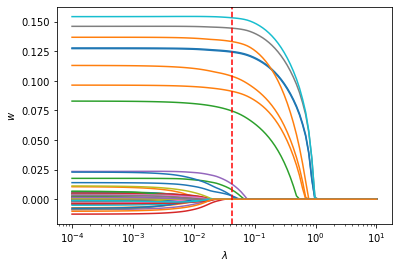

In [98]:
for k in range(p):
    plt.plot(lbda_list, W_Sparse[:,-1,k])
plt.xlabel('$\lambda$')
plt.ylabel('$w$')
plt.axvline(lambda_Sparse, color='red', linestyle='--')
plt.xscale('log')
# plt.legend()
plt.show()

In [99]:
selected_vars_Sparse = np.where(w_Sparse!=0)[0]
print(list(feature_colnames[selected_vars_Sparse]))

['pop', 'pctBlack', 'persUrban', 'persPoverty', 'kidsBornNevrMarr', 'pctKidsBornNevrMarr', 'numForeignBorn', 'houseVacant', 'pctVacantBoarded', 'persEmergShelt', 'persHomeless', 'pctUsePubTrans']


The selected feature names are displayed above

# Elastic Net

The regularization function of the Elastic Net is of the form:
\begin{equation}
    \lambda ||w||_{1} + \lambda * \gamma ||w||^{2}
\end{equation}

To get the proximal operator of the regularization function, we would have to solve the following:
\begin{equation}
    prox_{elasticnet(\lambda, \gamma)}(y) = argmin_{x} \frac{1}{2}||x-y||^{2} + \lambda ||x||_{1} + \lambda * \gamma ||x||^{2}
\end{equation}

By rearranging the terms in norm $L_2$, we can obtain that it is equivalent to
\begin{equation}
    prox_{elasticnet(\lambda, \gamma)}(y) = argmin_{x} \frac{1}{2}||x-\frac{y}{1+\lambda \gamma}||^{2} + \frac{\lambda}{1+\lambda \gamma} ||x||_{1}
\end{equation}
We come back to a form analogous to the one for the Lasso regularizer.
Hence we get
\begin{align}
    prox_{elasticnet(\lambda, \gamma)}(y) &= S_{\frac{\lambda}{1+\lambda \gamma}}(\frac{y}{1+\lambda \gamma})\\
    prox_{elasticnet(\lambda, \gamma)}(y) &= sign(\frac{y}{1+\lambda \gamma})(\frac{y}{1+\lambda \gamma}-\frac{\lambda}{1+\lambda \gamma})_{+}\\
    prox_{elasticnet(\lambda, \gamma)}(y) &= \frac{1}{1+\lambda \gamma} * sign(y) * (y-\lambda)_{+}\\
    prox_{elasticnet(\lambda, \gamma)}(y) &= \frac{1}{1+\lambda \gamma} * prox_{lasso(\lambda)}(y)\\
    prox_{elasticnet(\lambda, \gamma)}(y) &= prox_{ridge(\lambda \gamma)}(prox_{lasso(\lambda)}(y))
\end{align}

It is clear from the proximal operator that the Elastic Net combines the Ridge and the Lasso effects. So we expect sparsity in the coefficients

In [100]:
lbda = 0.1
gamma = 0.1
n_iter = 400
iast = optim.IAST(losses.LeastSquare, 'elasticnet', lbda=lbda, gamma=0.1)
w = iast.multiple_steps(X_train, y_train, tau=tau, n=n_iter)

### Find a good lambda and gamma

In [107]:
# 2D grid search. CAN BE VERY LONG TO RUN. I suggest to go to the next cell where you can load the data
# from .npy files
n_iter = 400
q = 100

lbda_list = np.logspace(-4,1,q)
gamma_list = np.logspace(-2,2,q)

E_train_Elastic = np.zeros((q,q))
E_test_Elastic = np.zeros((q,q))
W_Elastic = np.zeros((q,q,n_iter,p))

for i,lbda in enumerate(lbda_list):
    for j,gamma in enumerate(gamma_list):
        iast = optim.IAST(losses.LeastSquare, 'elasticnet', lbda=lbda, gamma=gamma)
        w = iast.multiple_steps(X_train, y_train, tau=tau, n=n_iter)

        E_train_Elastic[i,j] = iast.loss.loss(X_train,y_train,w)/np.linalg.norm(y_train)
        E_test_Elastic[i,j] = iast.loss.loss(X_test,y_test,w)/np.linalg.norm(y_test)
        W_Elastic[i,j] = iast.data['W']
    
# find optimal Lambda
i,j = np.unravel_index(E_test_Elastic.argmin(), E_test_Elastic.shape)
lambda_Elastic = lbda_list[i]
gamma_Elastic = gamma_list[j]
w_Elastic = W_Elastic[i,j,-1,:][:,None]
print( 'ElasticNet: ' + str(E_test_Elastic.min()*100) + '%' )
print('lambda = {}'.format(lambda_Elastic))
print('gamma = {}'.format(gamma_Elastic))
print('lambda * gamma = {}'.format(lambda_Elastic * gamma_Elastic))
# print('w = {}'.format(w_Elastic))

# np.save('data/E_train_Elastic.npy', E_train_Elastic)
# np.save('data/E_test_Elastic.npy', E_test_Elastic)
# np.save('data/W_Elastic.npy', W_Elastic)
# np.save('data/W_Elastic_short.npy', W_Elastic[:,:,-1:,:])

ElasticNet: 0.10835393697416326%
lambda = 0.037649358067924674
gamma = 18.73817422860385
lambda * gamma = 0.7054802310718645


In [103]:
# RUN THIS CELL TO SKIP THE GRID SEARCH AND LOAD THE DATA DIRECTLY.
# The saved file does not contain the value of w for each iteration, rather only for the last iteration
# (it requires around 3Gb file to save everything)
n_iter = 400
q = 100

lbda_list = np.logspace(-4,1,q)
gamma_list = np.logspace(-2,2,q)

E_train_Elastic = np.load('data/E_train_Elastic.npy')
E_test_Elastic = np.load('data/E_test_Elastic.npy')
# W_Elastic = np.load('data/W_Elastic.npy')
W_Elastic = np.load('data/W_Elastic_short.npy')

i,j = np.unravel_index(E_test_Elastic.argmin(), E_test_Elastic.shape)
lambda_Elastic = lbda_list[i]
gamma_Elastic = gamma_list[j]
w_Elastic = W_Elastic[i,j,-1,:][:,None]
print( 'ElasticNet: ' + str(E_test_Elastic.min()*100) + '%' )
print('lambda = {}'.format(lambda_Elastic))
print('gamma = {}'.format(gamma_Elastic))
print('lambda * gamma = {}'.format(lambda_Elastic * gamma_Elastic))
# print('w = {}'.format(w_Elastic))

ElasticNet: 0.10835393697416326%
lambda = 0.037649358067924674
gamma = 18.73817422860385
lambda * gamma = 0.7054802310718645


Let's have a look at the variation of the error as a function of $\lambda$ and $\gamma$. I propose several visualizations

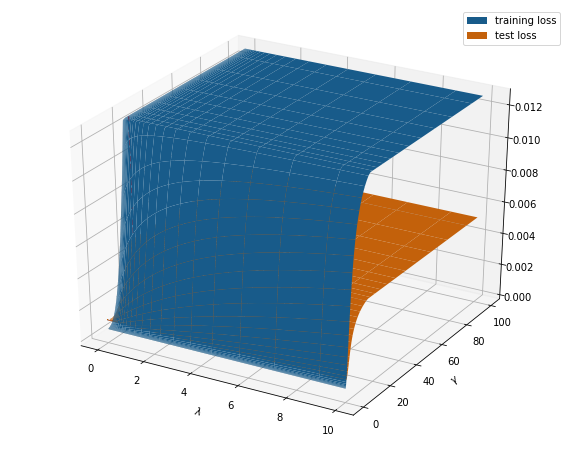

In [104]:
X,Y=np.meshgrid(lbda_list, gamma_list)
top_Z = max((E_train_Elastic).max(),
            (E_test_Elastic).max())
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
surf1 = ax.plot_surface(X, Y, E_train_Elastic, label='training loss')
surf1._facecolors2d=surf1._facecolors3d
surf1._edgecolors2d=surf1._edgecolors3d
surf = ax.plot_surface(X, Y, E_test_Elastic, label='test loss')
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d
ax.set_xlabel('$\lambda$')
ax.set_ylabel('$\gamma$')

# ax.set_xlim(-1,10)
# ax.set_ylim(-1,10)

ax.plot([lambda_Elastic, lambda_Elastic], [gamma_Elastic, gamma_Elastic], [0,top_Z], color='red', linestyle='--')
plt.legend()
plt.show()

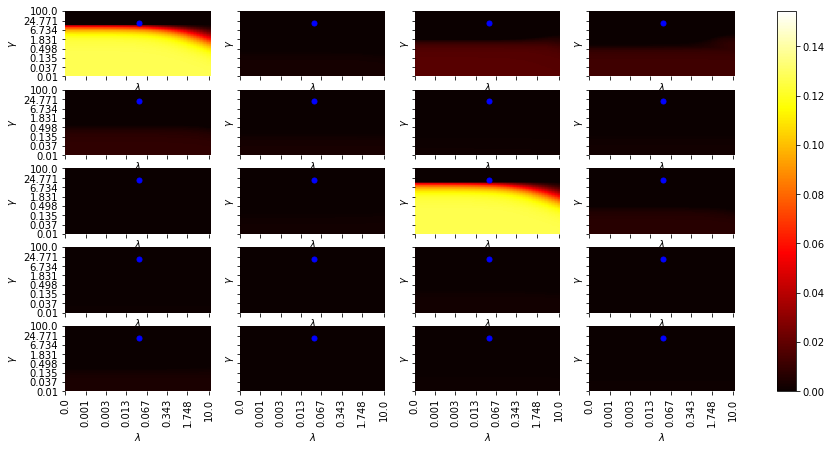

In [106]:
nb_ticks = 8 # choose the number of ticks of the heatmaps
max_rows = 5 # choose the max number of rows to display

idx_lbda_ticks = np.linspace(0, len(lbda_list)-1, nb_ticks, dtype=np.int)
lbda_ticks = np.round(lbda_list[idx_lbda_ticks],3)
idx_gamma_ticks = np.linspace(0, len(gamma_list)-1, nb_ticks, dtype=np.int)
gamma_ticks = np.round(gamma_list[idx_gamma_ticks],3)

lambda_Elastic_pos, gamma_Elastic_pos = np.unravel_index(E_test_Elastic.argmin(), E_test_Elastic.shape)

vmin = np.abs(W_Elastic[:,:,-1,:]).min()
vmax = np.abs(W_Elastic[:,:,-1,:]).max()

ncols = 4
nrows = min(p//ncols + (p%ncols!=0), max_rows)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (15,7), sharex=True, sharey=True)


for k in range(p):
    i,j = k//ncols, k%ncols
    if i>=nrows:
        break
    
    im = sns.heatmap(np.abs(W_Elastic[:,:,-1,k]), xticklabels=lbda_ticks, yticklabels=gamma_ticks,
                     ax=ax[i,j], cbar=False, cmap='hot', vmin=vmin, vmax=vmax)
    ax[i,j].set_xticks(idx_lbda_ticks)
    ax[i,j].set_yticks(idx_gamma_ticks)
    ax[i,j].invert_yaxis()
    ax[i,j].set_xlabel('$\lambda$')
    ax[i,j].set_ylabel('$\gamma$')
    ax[i,j].scatter(lambda_Elastic_pos, gamma_Elastic_pos, marker='.', s=100, color='blue') 
cbar = fig.colorbar(mappable = im.get_children()[0], ax=ax.ravel().tolist())

plt.show()

On the above heatmaps, we can see the value of the different components of $w$ as a function of $\lambda$ and $\gamma$. We see that the heatmap is black for many variables, which mean there are irrelevant or with a very low weight for the whole range of parameters for $\lambda$ and $\gamma$.

Now let's have a look at the variation of $w$ as a function of $\lambda$ and $\gamma$, or even $1/(1+\gamma)$, which represents the preponderance of the $L_1$ component compared to the $L_2$ component.

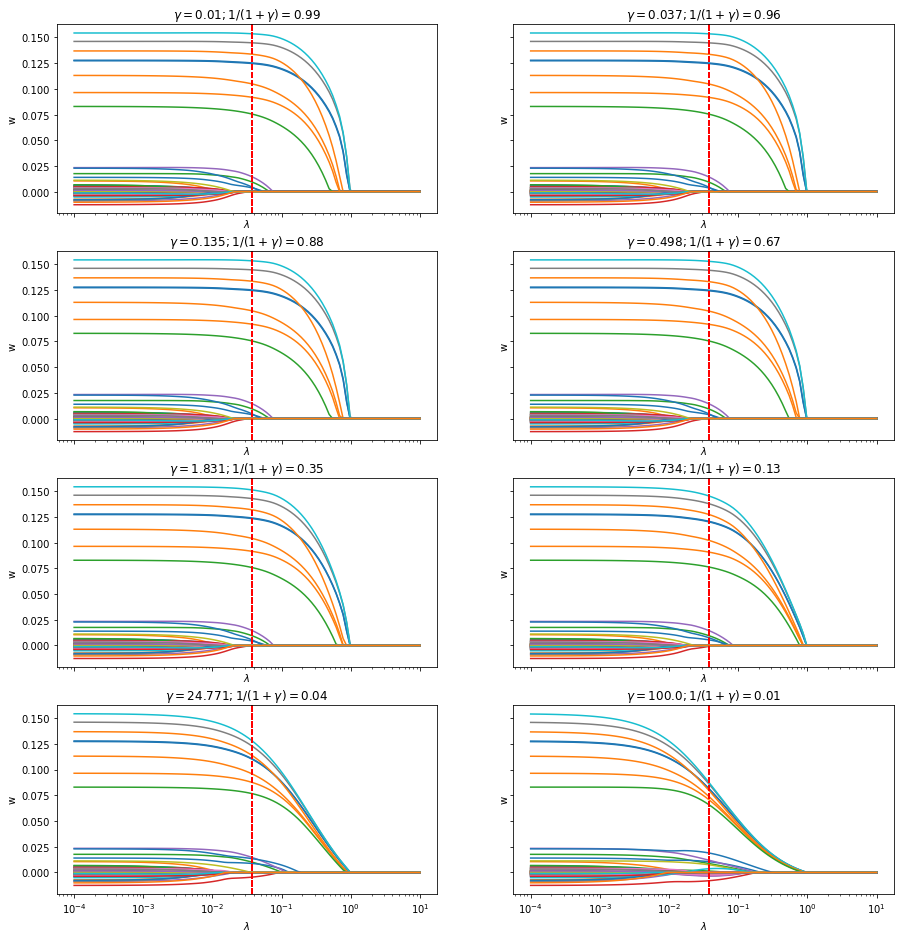

In [130]:
nb_ticks = 8
idx_lbda_ticks = np.linspace(0, len(lbda_list)-1, nb_ticks, dtype=np.int)
lbda_ticks = np.round(lbda_list[idx_lbda_ticks],3)
idx_gamma_ticks = np.linspace(0, len(gamma_list)-1, nb_ticks, dtype=np.int)
gamma_ticks = np.round(gamma_list[idx_gamma_ticks],3)

lambda_Elastic_pos, gamma_Elastic_pos = np.unravel_index(E_test_Elastic.argmin(), E_test_Elastic.shape)

ncols = 2
nrows = nb_ticks//ncols + (nb_ticks%ncols!=0)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (15,16), sharex=True, sharey=True)

for l,idx in enumerate(idx_gamma_ticks):
    i,j = l//ncols, l%ncols
    for k in range(p):
        ax[i,j].plot(lbda_list, W_Elastic[:,idx,-1,k])
        ax[i,j].set_xlabel('$\lambda$')
        ax[i,j].set_ylabel('w')
        ax[i,j].axvline(lambda_Elastic, color='red', linestyle='--')
        ax[i,j].set_xscale('log')
        ax[i,j].set_title('$\gamma = {}; 1/(1+\gamma)={}$'.format(gamma_ticks[l], np.round(1/(1+gamma_ticks[l]),2)))
# plt.legend()
plt.show()

What can we say from these plots ?

First, note the following: we have defined the Elastic Net regularization as
\begin{equation}
    \lambda ||w||_{1} + \lambda * \gamma ||w||^{2}
\end{equation}
the ratio of the $L_1$ component with respect to the total is:
\begin{equation}
    \frac{1}{1+\gamma}
\end{equation}
and for $L_2$ it is naturally:
\begin{equation}
    \frac{\gamma}{1+\gamma}
\end{equation}
So when $\frac{1}{1+\gamma}=0.99$, the $L_1$ component is really dominant; conversely, when $\frac{1}{1+\gamma}=0.01$, the Ridge component is dominant.

- first, we see the sparsity effect (selection of variables due to the $L_1$ component): when $\lambda$ is big enough, the coefficients $w$ are equal to zero.
- second, it looks like the curve of w as a function of $\lambda$ gets a visible inflexion point, as $\gamma$ increases (it is quite clear for $\frac{1}{1+\gamma} <=0.04$. There is a shift from the dominance of the Lasso component to the Ridge component of the regularization that come in effect. The variable selection effect is less important. Note equally for the group of lines with high values for $w$. When they decrease toward the 0 line, for high values of  $\frac{1}{1+\gamma}$, they decrease almost vertically: the variable selection effect is strong. For small values of  $\frac{1}{1+\gamma}$, the decrease is less sharp, less straight, and they join the 0 line at more similar values of $\lambda$, a little bit later, at least for the green line. You can look also at the group of less important variables, how the coefficients for these features join the 0 line earlier when $\frac{1}{1+\gamma}$ is high, compared to when it is small. So the $\gamma$ coefficient helps to modulate, to arbitrate between the $L_1$-type and $L_2$-type regularization.

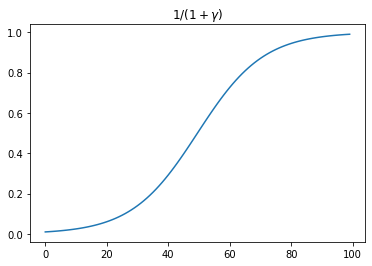

In [131]:
# the range of values taken by 1/(1+gamma)
plt.plot((1/(1+gamma_list))[::-1])
plt.title('$1/(1+\gamma)$')
plt.show()

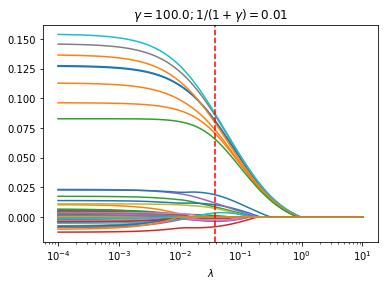

In [135]:
# to visualize one value in particular
gamma_idx = -1 # you can change the index here for the position in the array for the value of gamma
for k in range(p):
    plt.plot(lbda_list, W_Elastic[:,gamma_idx,-1,k])
plt.xlabel('$\lambda$')
plt.axvline(lambda_Elastic, color='red', linestyle='--')
plt.xscale('log')
plt.title('$\gamma = {}; 1/(1+\gamma)={}$'.format(gamma_ticks[l], np.round(1/(1+gamma_ticks[l]),2)))
plt.show()

# Group Lasso

The group lasso regularization function can be written as
\begin{equation}
    g(x)= \lambda \sum_{g\in G} ||x_g||_2
\end{equation}
Where $G$ is a partition of the variables (the variables are separated in a list of list).

- To find the proximal operator, let's first find the proximal operator of

\begin{equation}
    h(x) = \lambda ||x||_2
\end{equation}
We have:
\begin{equation}
    prox_{\lambda h}(y) = argmin_x \frac{1}{2}||x-y||^2 + \lambda||x||_2 = \phi(x)
\end{equation}
The function is convex (positive sum of norms), proper, coercive so it has a unique minimum. The function $\phi$ is differentiable except in 0. So the minimum will either make the gradient nul, either be 0.

Suppose the minimum is reached at $x \neq 0$. Let's calculate the gradient (for $x\neq 0$) and see what it gives:
    
\begin{align}
    \nabla_x \phi(x) &= x-y+\lambda\frac{x}{||x||} = 0 \\
    x(1+\lambda\frac{1}{||x||}) &= y
\end{align}
We assume of course that $\lambda >=0$, so $(1+\lambda\frac{1}{||x||})>=0$. By taking the $L_2$ norm on each side of the equality, we get:
\begin{align}
    ||x||(1+\lambda\frac{1}{||x||}) &= ||y|| \\
    ||x||+\lambda &= ||y||
\end{align}
We inject this into the precedent equation:
\begin{align}
    x(1+\lambda\frac{1}{||x||}) &= y \\
    x(||x||+\lambda) &= y ||x|| \\
    x||y|| &= y (||y||-\lambda) \\
    x^* &= (1-\frac{\lambda}{||y||}) y \\
\end{align}
We can safely divide by $||y||$ because, for example, $||y||=||x||+\lambda>0$. Note we have $||y||-\lambda=||x||>0$, which is used in the following calculations.
So the minimum is either reached at $x=0$, or $x=x^*$.

Reciprocally, if $||y||-\lambda > 0$, we calculate the value $\phi(x^*)$ and verify that the minimum is reached at $x^*$:
    
\begin{align}
    \phi(x^*) &= \frac{1}{2}||\frac{\lambda}{||y||}y||^2 + \lambda||(1-\frac{\lambda}{||y||}) y|| \\
    \phi(x^*) &= \frac{1}{2}\lambda^2{||y||^2}y||^2 + \lambda (1-\frac{\lambda}{||y||}) ||y|| \\
    \phi(x^*) &= -\frac{1}{2}\lambda^2 + \lambda||y||
\end{align}
The value $\phi(0)$ is
\begin{equation}
    \phi(0)= \frac{1}{2} ||y||^2
\end{equation}

We then calculate $\phi(0)-\phi(x^*)$
\begin{align}
    \phi(0)-\phi(x^*) &= \frac{1}{2} ||y||^2 -\lambda||y|| +\frac{1}{2}\lambda^2 \\
    \phi(0)-\phi(x^*) &= \frac{1}{2} (||y||-\lambda)^2 >0
\end{align}
So the minimum is attained at $x=x^*$ if $||y||-\lambda>=0$, and else at $x=0$.

We can easily find a good formulation for this:
\begin{equation}
    prox_{\lambda h}(y) = (1-\frac{\lambda}{||y||})_{+} y
\end{equation}

- Now let's continue for the function

\begin{equation}
    g(x)= \lambda \sum_{g\in G} ||x_g||_2
\end{equation}
It suffices to notice that:
\begin{equation}
    prox_{\lambda g}(y) = argmin_x \frac{1}{2}||x-y||^2 + \lambda \sum_{g\in G} ||x_g||_2 = argmin_x \sum_{g\in G} \frac{1}{2}||x_g-y_g||^2 + \lambda  ||x_g||_2
\end{equation}
We can optimize independently for each group $g$:
\begin{equation}
    (prox_{\lambda g}(y))_g = prox_{\lambda h}(y_g)
\end{equation}

- So to summarize:

\begin{equation}
    (prox_{\lambda g}(y))_g = (1-\frac{\lambda}{||y_g||})_{+} y_g
\end{equation}

The IAST algorithm is used from these information

We tried to do groups of variables based on the fact that the variables are about the same family of information. You can see below the groups, presented as a dictionary

In [18]:
# we present the groups as a dictionary (I did a little bit of data wrangling to get this,
# things start to get cumbursome we we have a lot of features !!!)

grouped_columns = {
 'pop':['pop'],
 'perHoush':['perHoush'],
 'race':['pctBlack',
  'pctWhite',
  'pctAsian',
  'pctHisp',
  'pct12-21',
  'pct12-29',
  'pct16-24',
  'pct65up'],
 'urban':['persUrban', 'pctUrban'],
 'income':['medIncome',
  'pctWwage',
  'pctWfarm',
  'pctWdiv',
  'pctWsocsec',
  'pctPubAsst',
  'pctRetire',
  'medFamIncome',
  'perCapInc',
  'whitePerCap',
  'blackPerCap',
  'NAperCap',
  'asianPerCap',
  'otherPerCap',
  'hispPerCap'],
 'poverty':['persPoverty', 'pctPoverty'],
 'occupation':['pctLowEdu',
  'pctNotHSgrad',
  'pctCollGrad',
  'pctUnemploy',
  'pctEmploy',
  'pctEmployMfg',
  'pctEmployProfServ',
  'pctOccupManu',
  'pctOccupMgmt'],
 'situation':['pctMaleDivorc', 'pctMaleNevMar', 'pctFemDivorc', 'pctAllDivorc'],
 'family':['persPerFam',
  'pct2Par',
  'pctKids2Par',
  'pctKids-4w2Par',
  'pct12-17w2Par',
  'pctWorkMom-6',
  'pctWorkMom-18',
  'kidsBornNevrMarr',
  'pctKidsBornNevrMarr',
  'numForeignBorn'],
 'immigration':['pctFgnImmig-3',
  'pctFgnImmig-5',
  'pctFgnImmig-8',
  'pctFgnImmig-10',
  'pctImmig-3',
  'pctImmig-5',
  'pctImmig-8',
  'pctImmig-10'],
 'language':['pctSpeakOnlyEng', 'pctNotSpeakEng'],
 'home':['pctLargHousFam',
  'pctLargHous',
  'persPerOccupHous',
  'persPerOwnOccup',
  'persPerRenterOccup',
  'pctPersOwnOccup',
  'pctPopDenseHous',
  'pctSmallHousUnits',
  'medNumBedrm',
  'houseVacant',
  'pctHousOccup',
  'pctHousOwnerOccup',
  'pctVacantBoarded',
  'pctVacant6up',
  'medYrHousBuilt',
  'pctHousWOphone',
  'pctHousWOplumb'],
 'rent':['ownHousLowQ',
  'ownHousMed',
  'ownHousUperQ',
  'ownHousQrange',
  'rentLowQ',
  'rentMed',
  'rentUpperQ',
  'rentQrange ',
  'medGrossRent',
  'medRentpctHousInc',
  'medOwnCostpct',
  'medOwnCostPctWO'],
 'precarious':['persEmergShelt', 'persHomeless', 'pctForeignBorn', 'pctBornStateResid'],
 'mobility':['pctSameHouse-5', 'pctSameCounty-5', 'pctSameState-5'],
 'policeNb':['numPolice',
  'policePerPop',
  'policeField',
  'policeFieldPerPop',
  'policeCalls',
  'policCallPerPop',
  'policCallPerOffic',
  'policePerPop2'],
 'policeRace':['racialMatch',
  'pctPolicWhite',
  'pctPolicBlack',
  'pctPolicHisp',
  'pctPolicAsian',
  'pctPolicMinority'],
 'policeOps':['officDrugUnits',
  'numDiffDrugsSeiz',
  'policAveOT',
  'landArea',
  'popDensity',
  'pctUsePubTrans',
  'policCarsAvail',
  'policOperBudget',
  'pctPolicPatrol',
  'gangUnit',
  'pctOfficDrugUnit', 
  'policBudgetPerPop']
}

In [19]:
# We have the columns that have been removed from the dataset
print(sum([len(x) for x in grouped_columns.values()]))

# we remove them
grouped_columns = {k:[var for var in v if var in df.columns] for k,v in grouped_columns.items()}
grouped_columns = {k:v for k,v in grouped_columns.items() if v!=[]}
print(sum([len(x) for x in grouped_columns.values()]))

124
102


In [20]:
grouped_columns_nb = {k:[df.columns.get_loc(col) for col in v] for k,v in grouped_columns.items()}

In [21]:
groups_col = list(grouped_columns.values())
groups = list(grouped_columns_nb.values())

### basic test

In [24]:
lbda = 0.1
n_iter = 400
iast = optim.IAST(losses.LeastSquare, 'group_lasso', lbda=lbda, groups=groups)
w = iast.multiple_steps(X_train, y_train, tau=tau, n=n_iter)

### Find a good lambda and gamma

In [25]:
n_iter = 400
q = 100
lbda_list = np.logspace(-4,1,q)

E_train_GroupLasso = np.zeros(q)
E_test_GroupLasso = np.zeros(q)
W_GroupLasso = np.zeros((q,n_iter,p))

for i,lbda in enumerate(lbda_list):
    iast = optim.IAST(losses.LeastSquare, 'group_lasso', lbda=lbda, groups=groups)
    w = iast.multiple_steps(X_train, y_train, tau=tau, n=n_iter)

    E_train_GroupLasso[i] = iast.loss.loss(X_train,y_train,w)/np.linalg.norm(y_train)
    E_test_GroupLasso[i] = iast.loss.loss(X_test,y_test,w)/np.linalg.norm(y_test)
    W_GroupLasso[i] = iast.data['W']
    
# find optimal Lambda
i = np.unravel_index(E_test_GroupLasso.argmin(), E_test_GroupLasso.shape)
lambda_GroupLasso = lbda_list[i]
w_GroupLasso = W_GroupLasso[i,-1,:][:,None]
print( 'Group Lasso: ' + str(E_test_GroupLasso.min()*100) + '%' )
print('lambda = {}'.format(lambda_GroupLasso))
# print('w = {}'.format(w_GroupLasso))

Group Lasso: 0.11095003376602719%
lambda = 0.09545484566618337


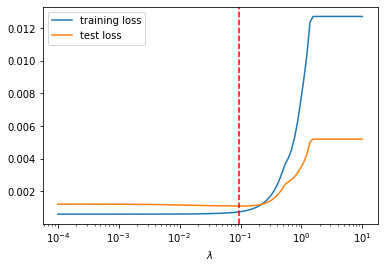

In [26]:
plt.clf
plt.plot(lbda_list, E_train_GroupLasso, label='training loss')
plt.plot(lbda_list, E_test_GroupLasso, label='test loss')
plt.axvline(lambda_GroupLasso, color='red', linestyle='--')
plt.xlabel('$\lambda$')
# plt.xlim(0.001,0.1)
plt.xscale('log')
plt.legend()
plt.show()

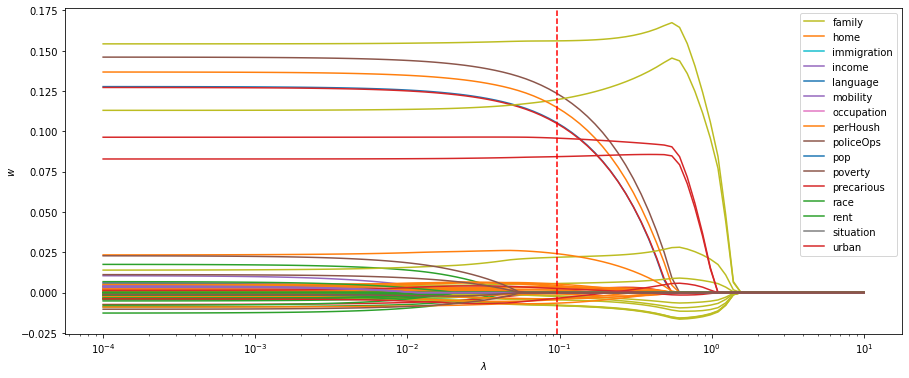

In [27]:
fig, ax = plt.subplots(1, figsize=(15,6))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors = itertools.cycle(colors)

for group_name, group in grouped_columns_nb.items():
    color = next(colors)
    ax.plot(lbda_list, W_GroupLasso[:,-1,group], label=group_name, color=color)
ax.set_xlabel('$\lambda$')
ax.set_ylabel('$w$')
ax.axvline(lambda_GroupLasso, color='red', linestyle='--')
ax.set_xscale('log')

handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
plt.legend(handles, labels, loc='best')

plt.show()

In [40]:
# the selected groups
selected_group_names = []
for group_name, group in grouped_columns_nb.items():
    if not np.isclose(w_GroupLasso[:,-1,group], np.zeros((1,1,len(group)))).all():
        selected_group_names.append(group_name)
        
selected_group_names

['pop', 'urban', 'poverty', 'family', 'home', 'precarious']

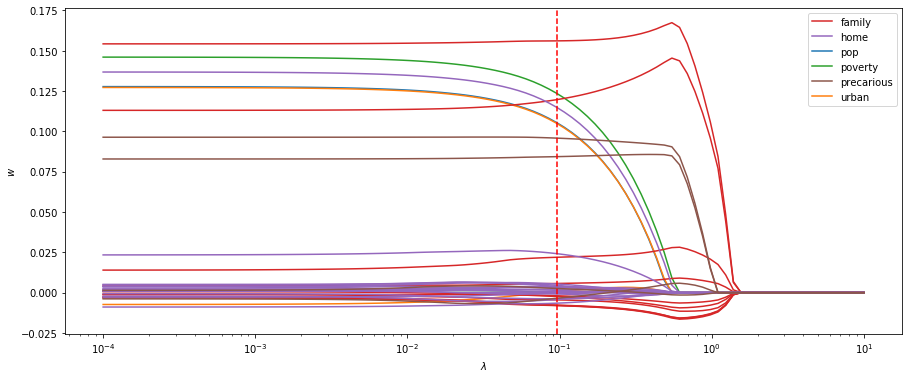

In [41]:
# we print here the w for the selected groups only
group_indices = selected_group_names

fig, ax = plt.subplots(1, figsize=(15,6))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors = itertools.cycle(colors)

for i,(group_name, group) in enumerate(grouped_columns_nb.items()):
    if group_indices!=[]:
        if group_name not in group_indices:
            continue
    color = next(colors)
    ax.plot(lbda_list, W_GroupLasso[:,-1,group], label=group_name, color=color)
ax.set_xlabel('$\lambda$')
ax.set_ylabel('$w$')
ax.axvline(lambda_GroupLasso, color='red', linestyle='--')
ax.set_xscale('log')

handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
plt.legend(handles, labels, loc='best')

plt.show()

What is interesting to see is that the sparcity comes into effect for variables of the same group at the same time, in other words for the same value of $\lambda$. On the plot above, variables from the same group have the same color. They all reach value 0 at the same value of $\lambda$


We can see this better by selecting a given group. Put the groups of variables you want to watch in list group_indices below. It will only display them

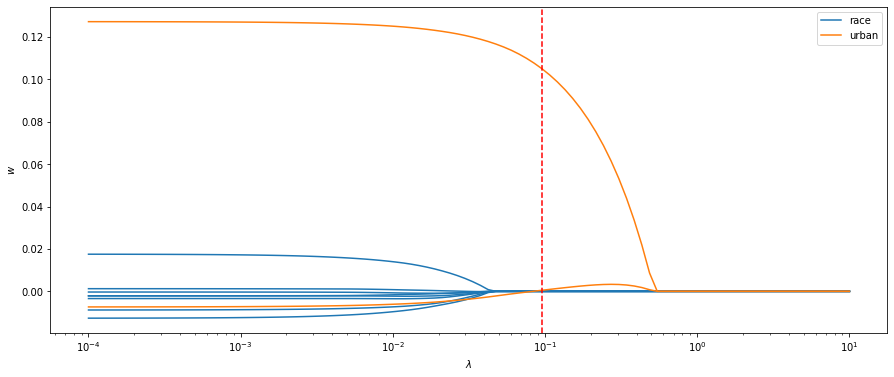

In [155]:
group_indices = [2,3]

fig, ax = plt.subplots(1, figsize=(15,6))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors = itertools.cycle(colors)

for i,(group_name, group) in enumerate(grouped_columns_nb.items()):
    if group_indices!=[]:
        if i not in group_indices:
            continue
    color = next(colors)
    ax.plot(lbda_list, W_GroupLasso[:,-1,group], label=group_name, color=color)
ax.set_xlabel('$\lambda$')
ax.set_ylabel('$w$')
ax.axvline(lambda_GroupLasso, color='red', linestyle='--')
ax.set_xscale('log')

handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
plt.legend(handles, labels, loc='best')

plt.show()

The group lasso has the benefit to be able to do variable selection by group. Here, we could make relevant groups of variables. And the group Lasso is able to tell us which group have an important prediction power, and which have not.
In our dataset, we mainly deal with real variables. But in case of categorical variables, we could regroup the one-hot encoded variables of the same original variable as a group, for example.

# Comparison of results

We now compare the results for all the methods

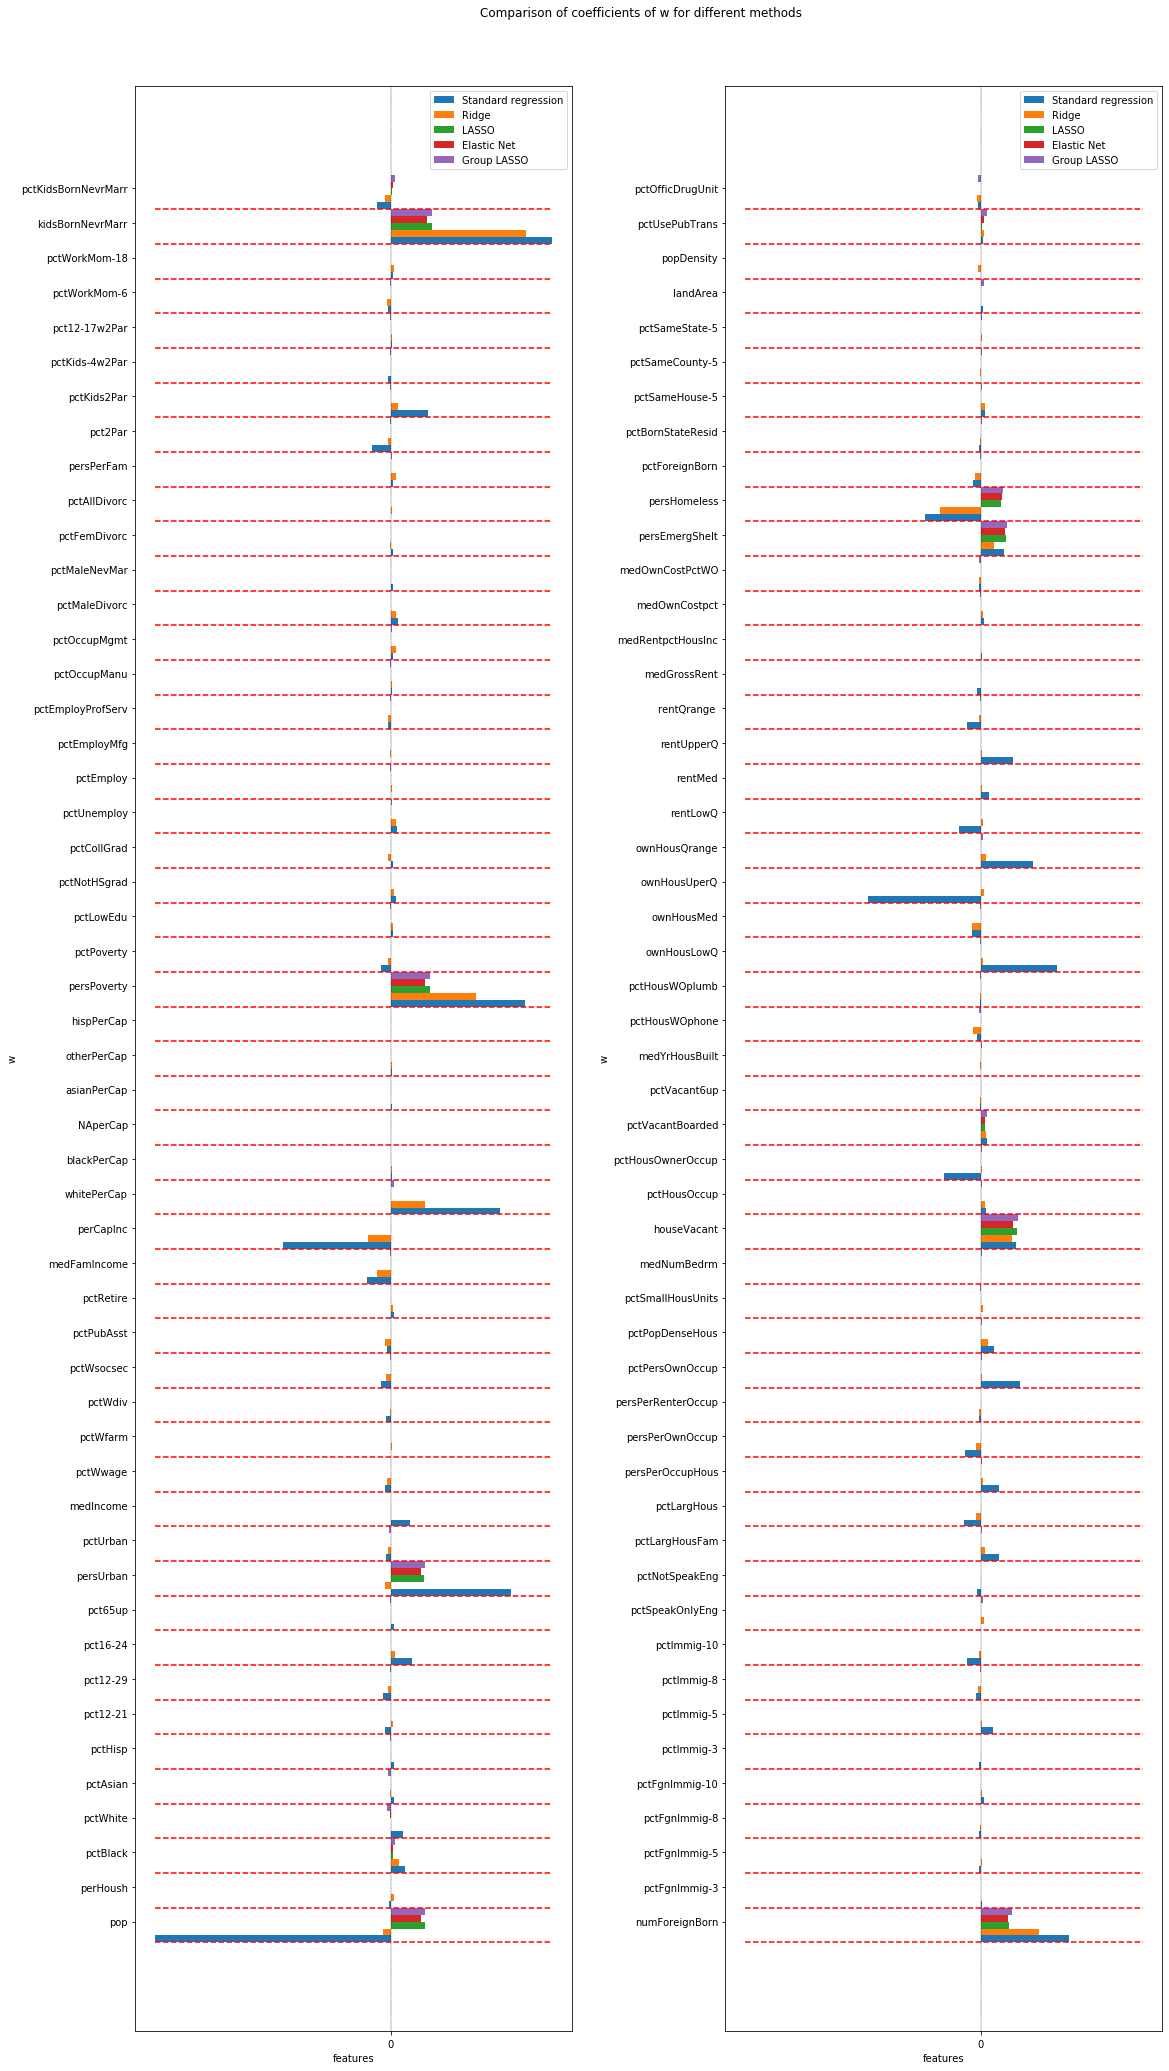

In [284]:
indices = np.arange(1,p+1) 

Ws = {'Standard regression':w_Reg,
      'Ridge':w_Ridge,
      'LASSO':w_Sparse,
      'Elastic Net':w_Elastic,
      'Group LASSO':w_GroupLasso}

xmin, xmax = min(min(v) for v in Ws.values()), max(max(v) for v in Ws.values())
total_width = 1
width = total_width / len(Ws)
start_pos = -(len(Ws)%2)/2-len(Ws)//2

ncols=2
idx_cut = int(p/ncols)
fig, ax = plt.subplots(ncols=ncols, figsize=(15,30), sharex=True)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
for i in range(ncols):
    idx_min, idx_max = i*idx_cut, min((i+1)*idx_cut, p)
    
    for j,(k,v) in enumerate(Ws.items()):
        ax[i].barh(indices[idx_min:idx_max]+start_pos*width+j*width, v[idx_min:idx_max,0], height=width, label=k)
    
#     ax[i].barh(indices[idx_min:idx_max]-2*width, w_Reg[idx_min:idx_max,0], height=width, label='Standard regression')
#     ax[i].barh(indices[idx_min:idx_max]-1*width, w_Sparse[idx_min:idx_max,0], height=width, label='LASSO')
#     ax[i].barh(indices[idx_min:idx_max]+1*width, w_Elastic[idx_min:idx_max,0], height=width, label='Elastic Net')
#     ax[i].barh(indices[idx_min:idx_max]+2*width, w_GroupLasso[idx_min:idx_max,0], height=width, label='Group LASSO')
    
    ax[i].set_yticks(indices[idx_min:idx_max])
    ax[i].set_yticklabels(list(feature_colnames[idx_min:idx_max]))
    
#     ax[i].axhline([5,10], color='red', linestyle='--')
    ax[i].hlines(indices[idx_min:idx_max]+start_pos*width-width/2, xmin=xmin, xmax=xmax, color='red', linestyle='--')
    ax[i].axvline(0, color='black', linestyle='--', linewidth=0.4)
    
    ax[i].set_xscale('symlog') # COMMENT THIS LINE TO GET A NORMAL SCALE
    
    ax[i].set_xlabel('features')
    ax[i].set_ylabel('w')
    ax[i].legend()

plt.subplots_adjust(wspace=0.35)
plt.suptitle('Comparison of coefficients of w for different methods')
plt.show()

We can see that of course the coefficient values are greater and not null for more variables with the standard regression. With Ridge regression, we already see that the coefficients are much closer to 0.

LASSO non null coefficient are much rarer, same for Elastic Net and Group Lasso.

We can also see that the coefficient for pop is negative for Standard regression and Ridge, and positive for the other methods. Several variables have correlated effects. The selection variable procedures might have eliminated the variables correlated with pop

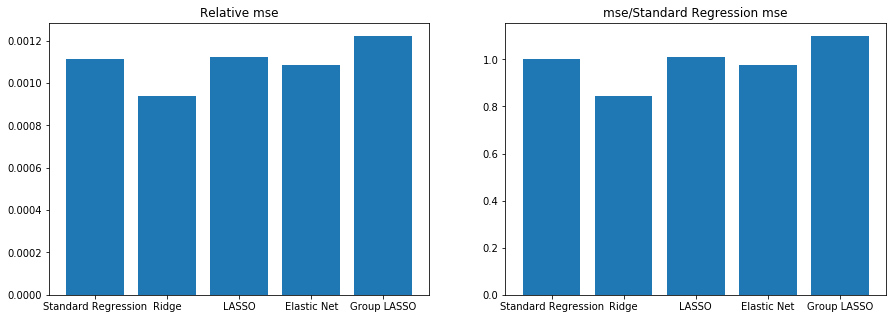

In [281]:
mse_perf = {
    'Standard Regression':relative_mse(X_test@w_Reg, y_test),
    'Ridge':relative_mse(X_test@w_Ridge, y_test),
    'LASSO':relative_mse(X_test@w_Sparse, y_test),
    'Elastic Net':relative_mse(X_test@w_Elastic, y_test),
    'Group LASSO':relative_mse(X_test@w_GroupLasso, y_test)
}

fig, ax = plt.subplots(ncols=2, figsize = (15,5))
ax[0].bar(range(len(mse_perf)), list(mse_perf.values()), align='center')
ax[0].set_xticks(range(len(mse_perf)))
ax[0].set_xticklabels(list(mse_perf.keys()))
ax[0].set_title('Relative mse')

ax[1].bar(range(len(mse_perf)), list(mse_perf.values())/mse_perf['Standard Regression'], align='center')
ax[1].set_xticks(range(len(mse_perf)))
ax[1].set_xticklabels(list(mse_perf.keys()))
ax[1].set_title('mse/Standard Regression mse')
plt.show()

We can see that the performances are relatively close between methods. Ridge has an edge, though.
Worth to note, the LASSO has a similar performance to Standard Regression, with the benefit of variable selection. Elastic Net do slightly better with still variable selection. The group LASSO method is slightly worse, maybe the groups were not that relevant. Anyway, thanks to the Group LASSO, we could uncover groups of variables that have an impact to orient the efforts of policy makers and public authorities by giving a clear message on what aspect is important to reduce the crime rate.

Concerning the IAST algorithm, the running time seemed reasonable. Otherwise, it might have been possible to try the accelerated version of it